In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:22<00:00,  5.64it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [6]:
# Changed: Removed the markdown from questions

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [8]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [9]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [11]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [13]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [14]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [15]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [16]:
#Changed: Added some more keywords2search

In [17]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy",
                  "code here", "pts", "instead", "try", "why",
                  "hint", "Traceback", "most recent call last",
                  "google", "http"]

keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [18]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,#try,#why,#hint,#traceback,#most recent call last,#google,#http,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,2.0,3.0,5.0,6.0,6.0,1.0,0.0,0.017986,18.850913


In [19]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


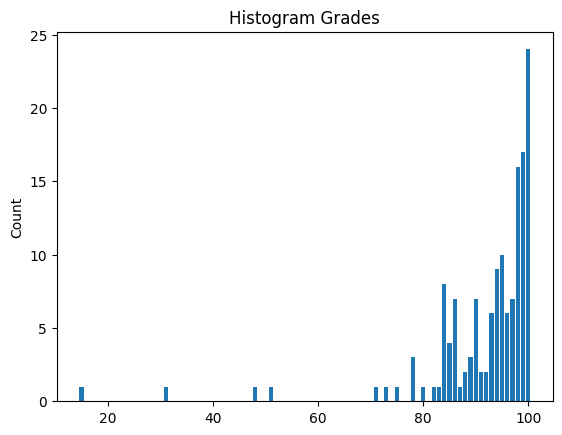

In [20]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [21]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,#try,#why,#hint,#traceback,#most recent call last,#google,#http,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,2.0,3.0,5.0,6.0,6.0,1.0,0.0,0.017986,18.850913


In [22]:
#df = pd.merge(df, question_mapping_scores, on="code", how="left") #Changed
df = pd.merge(df, question_mapping_scores, on="code")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 122
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code                    123 non-null    object 
 1   #user_prompts           123 non-null    float64
 2   #error                  123 non-null    float64
 3   #no                     123 non-null    float64
 4   #thank                  123 non-null    float64
 5   #next                   123 non-null    float64
 6   #entropy                123 non-null    float64
 7   #code here              123 non-null    float64
 8   #pts                    123 non-null    float64
 9   #instead                123 non-null    float64
 10  #try                    123 non-null    float64
 11  #why                    123 non-null    float64
 12  #hint                   123 non-null    float64
 13  #traceback              123 non-null    float64
 14  #most recent call last  123 non-null    fl

**Running sentiment analysis on every prompt to find the average sentiment of the user throughout the conversation. This might be helpful to us. At this point, we are desperate for any sort of correlation.**

In [23]:
#Changed: This whole part is added later

In [24]:
#Let's start by defining some useful functions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    # Use BeautifulSoup to parse the HTML and extract text
    soup = BeautifulSoup(text, 'html.parser')
    
    # Use get_text() to extract text content without HTML tags
    cleaned_text = soup.get_text(separator=' ', strip=True)
    
    return cleaned_text

def remove_punctuation(text):
    remove_these = ['"', '#', '$', '%', '&', "'", '(', ')', '*', 
                    ',', '.', '/', ':', ';', '<', '=', '>', '@', 
                    '[', '\\', ']', '^', '_', '`', '{', '|', '}', 
                    '~', '-', '+', '-', '!', '?']
    for i in remove_these:
        text = text.replace(i, "")
    return text

def remove_stopwords(vector):
    
    new_vector = []
    
    for word in vector:
        if word not in stop_words:
            new_vector.append(word)
        
    return new_vector

def stemming(vector):
    
    new_vector = []
    
    for word in vector:
        new_vector.append(stemmer.stem(word))
    
    return new_vector

def vector_to_string(vector):
    return ' '.join(vector)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARDA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
prompts = []
ID2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            
            unparsed_text = conv["text"]
            
            unparsed_text = remove_html_tags(unparsed_text)
            unparsed_text = unparsed_text.lower()
            unparsed_text = remove_punctuation(unparsed_text)
            
            unparsed_tokens = word_tokenize(unparsed_text)
            unparsed_tokens = remove_stopwords(unparsed_tokens)
            unparsed_tokens = stemming(unparsed_tokens)
            
            parsed_text = vector_to_string(unparsed_tokens)
                
            prompts.append(parsed_text)
            user_prompts.append(parsed_text)
            
    ID2prompts[code] = user_prompts    

C:\Users\ARDA\AppData\Local\Temp\ipykernel_19408\817832833.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [26]:
#Let's see an example
pprint(ID2prompts["0031c86e-81f4-4eef-9e0e-28037abf9883"])

['load csv file panda python file name cs412hw1datasetcsv contain column like '
 'speci island sex diet year life stage bodi mass g bill length mm bill depth '
 'mm flipper length mm health metric',
 'provid python code understand dataset use panda find shape dataset display '
 'variabl name display summari dataset info function show first 5 row use head '
 'function',
 'preprocess data 1 check miss valu handl either drop fill common valu ensur '
 'enough data train model use 80 data train 20 test 2 encod label map use map '
 'function map name sexmap femal 1 male 0 islandmap bisco 1 dream 2 torgensen '
 '3 dietmap fish 1 krill 2 squid 3 parent 4 lifestagemap chick 1 juvenil 2 '
 'adult 3 healthmetricsmap healthi 1 overweight 2 underweight 3 dataset name '
 'df',
 'alreadi provid code pleas recreat part shuffl need 1 shuffl datafram name df '
 '2 separ dataset featur matrix x target vector column healthmetr column '
 'includ x 3 split data train test set 80 data train 20 test ensur spl

In [27]:
#Now, let us use a pretrained sentiment classifier from huggingface

import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm

#Get the huggingface model from https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

#Calculate the sentiment score for a text
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.softmax(dim=-1).detach().numpy()[0]


user_sentiments = []

#Max sequence length is 512 for this model, so we limit
for user_id, texts in tqdm(ID2prompts.items(), desc="Calculating Sentiment"):
    user_sentiment_scores = [get_sentiment(text[:512:]) for text in texts]
    
    #stop div by 0
    if(len(user_sentiment_scores) != 0):
        average_sentiment = sum(score[1] for score in user_sentiment_scores) / (len(user_sentiment_scores)) 
        user_sentiments.append({'user_id': user_id, 'average_sentiment': average_sentiment})   
    else:
        user_sentiments.append({'user_id': user_id, 'average_sentiment': 0})

Calculating Sentiment: 100%|█████████████████████████████████████████████████████████| 127/127 [03:16<00:00,  1.55s/it]


In [28]:
sentiment_df = pd.DataFrame(columns=['ID', 'Average Sentiment'])

for entry in user_sentiments:
    key = entry["user_id"]
    value = entry["average_sentiment"]    
    concat2df = pd.DataFrame({'ID': [key], 'Average Sentiment': [value]})
    sentiment_df = pd.concat([sentiment_df, concat2df], ignore_index=True)
    
sentiment_df.head()   

,ID,Average Sentiment
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.085882
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.175875
2,041f950b-c013-409a-a642-cffff60b9d4b,0.138399
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.052330
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.172591


In [29]:
#Let's merge sentiment_df with the first df we created which has everything but scores at this point

df = df.rename(columns={'code': 'ID'})

df = pd.merge(df, sentiment_df, on='ID', how='inner')

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average Sentiment
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,0.085882
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,0.175875
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,0.138399
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,0.052330
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,0.172591


In [30]:
#Changed: Lastly, get and merge the submission dates with our dataset:

dates_path = "dates.txt" #We scraped this information elsewhere
columns = ["ID", "date"]

dates_df = pd.read_csv(dates_path, sep=' ', header=None, names=columns)

#Let's represent each date as its distance from the latest submission date
lastest = dates_df['date'].max()
dates_df['date'] = abs(lastest - dates_df['date'])

df = pd.merge(df, dates_df, on='ID')

#### Merging scores with features

In [31]:
#Let's finally merge everything with scores
scores = scores.rename(columns={'code': 'ID'})
df = pd.merge(df, scores, on='ID', how="left")
df.dropna(inplace=True)
df.drop_duplicates("ID",inplace=True, keep="first")

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average Sentiment,date,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,0.085882,0,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,0.175875,0,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,0.138399,0,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,0.052330,16,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,0.172591,0,100.0


In [32]:
#Changed: Now, let's factor in the weights of the questions as well

#Drop Q_0 since it has no points
df = df.drop('Q_0', axis=1)

df["Q_1"] = df["Q_1"] * 5
df["Q_2"] = df["Q_2"] * 15
df["Q_3"] = df["Q_3"] * 5  
df["Q_4"] = df["Q_4"] * 10
df["Q_5"] = df["Q_5"] * 20
df["Q_6"] = df["Q_6"] * 15
df["Q_7"] = df["Q_7"] * 20
df["Q_8"] = df["Q_8"] * 10

df.head()

,ID,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average Sentiment,date,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,7.832540,1.761215,4.606063,11.077513,2.508756,3.658762,1.954398,0.085882,0,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,...,11.582763,4.413282,6.071144,19.750224,13.388784,11.414811,5.438659,0.175875,0,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,10.0,0.0,...,9.372367,1.759359,6.430377,9.086289,8.104040,10.930117,3.257926,0.138399,0,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,4.010183,1.584045,3.338891,6.181681,2.886515,5.237849,4.071058,0.052330,16,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,7.0,0.0,...,11.743251,3.124165,7.248722,17.443416,10.271962,18.906107,5.117691,0.172591,0,100.0


In [33]:
df.describe()

,#user_prompts,#error,#no,#thank,#next,#entropy,#code here,#pts,#instead,#try,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average Sentiment,date,grade
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,28.827869,2.229508,0.737705,0.188525,0.245902,4.319672,1.409836,6.131148,0.467213,0.967213,...,8.108406,2.952814,6.604589,12.467524,8.956276,10.966658,4.847558,0.150505,3.303279,91.754098
std,20.960684,3.494475,1.251797,0.708064,0.947476,6.140593,3.272106,8.566657,0.980676,1.675957,...,4.289305,1.592710,2.653022,6.150843,4.957962,6.078383,2.228953,0.083642,4.952484,12.419201
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.686794,0.000000,0.226145,0.798471,0.491053,0.332692,0.283831,0.005866,0.000000,15.000000
25%,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,4.048895,1.356284,5.550632,7.450836,3.988961,5.445093,3.248605,0.086249,0.000000,89.250000
50%,21.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,...,8.024293,3.508573,6.873267,14.588941,10.154859,11.414811,5.085936,0.139303,0.000000,95.000000
75%,39.250000,3.000000,1.000000,0.000000,0.000000,4.000000,2.000000,10.000000,1.000000,1.000000,...,11.965661,4.275518,9.135721,17.785172,14.056187,16.968121,6.751793,0.191866,6.000000,99.000000
max,100.000000,23.000000,5.000000,5.000000,6.000000,40.000000,21.000000,47.000000,7.000000,11.000000,...,15.000000,5.000000,10.000000,20.000000,15.000000,20.000000,8.956850,0.469764,20.000000,100.000000


In [34]:
X = df[df.columns[1:-1]].to_numpy()
y = df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 28) (122,)


#### Train/Test split

In [47]:
#Changed
#Since we have so little data, startification doesn't really work because we don't have enough different
#y values. So instead, I wrote this simple code to split it until we get a good result. I would have used
#StratifiedShuffleSplit or something similar if we had more data.

condition = True
iteration_count = 0

while condition:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mean_y_train = y_train.mean()
    mean_y_test = y_test.mean()
    condition = (abs(mean_y_train - mean_y_test) >= 1)
    iteration_count += 1
    
print("Train set size and mean:", len(X_train), mean_y_train)
print("Test set size and mean:", len(X_test), mean_y_test)
print("Arrived at this with {} iterations.".format(iteration_count))

Train set size and mean: 97 91.6082474226804
Test set size and mean: 25 92.32
Arrived at this with 1 iterations.


#### Fitting a model

In [50]:
#Changed: Let's train a simple neural network for finding a relation between all these features and the grade

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, input_shape=(28,), activation='relu'), #We set the input shape 28 since we have 28 features
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  #Sigmoid activation for values between 0 and 1
])

#Scale the output to be in the range of 0 to 100
model.add(layers.Lambda(lambda x: x * 100))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  #We are using mean absolute error

print(model.summary())

#Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=16, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               3712      
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
5/5 [==============================] - 1s 45ms/step - loss: 2126.3247 - mae: 32.5342 - val_loss: 114.1073 - val_mae: 7.1566
Epoch 2/4
5/5 [==============================

In [51]:
#Make predictions
predictions = model.predict(X_test)

#Compare predictions with actual scores
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison_df)

1/1 [==============================] - 0s 66ms/step
    Actual   Predicted
0    100.0   99.982109
1     98.0   99.348633
2     99.0  100.000000
3     88.0   99.999977
4     98.0   99.999794
5     92.0  100.000000
6     95.0   99.999985
7     97.0  100.000000
8     96.0  100.000000
9     99.0  100.000000
10    96.0  100.000000
11    93.0   99.999985
12   100.0   99.999985
13    84.0  100.000000
14   100.0  100.000000
15    80.0   99.999931
16    99.0   99.999847
17   100.0   99.999496
18    89.0  100.000000
19   100.0   99.993599
20    78.0   99.999985
21   100.0   99.997673
22    98.0   99.999680
23    31.0  100.000000
24    98.0  100.000000


**On 23rd line we predicted that someone who got 31 got 100. This is really bad. Our model has a low MAE because it just assigns every student high grades, and since most people got high grades from the homework, this does not seem to be useful.**

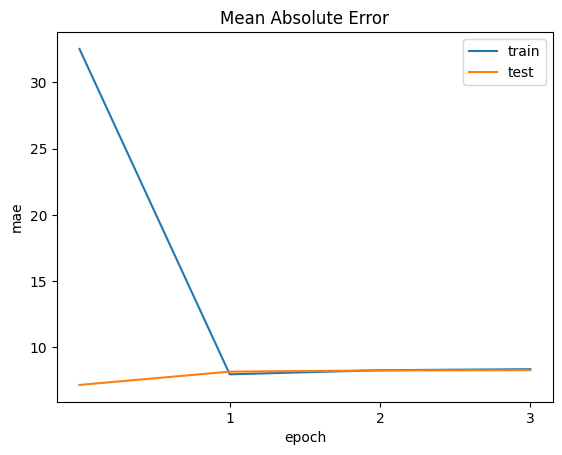

In [63]:
#Let's visualize the mean absolute error

#print(history.history.keys())

plt.plot(history.history['mae']) 
plt.plot(history.history['val_mae']) 
plt.title('Mean Absolute Error') 
plt.ylabel('mae') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper right') 
plt.xticks(range(1, 4))
plt.show()

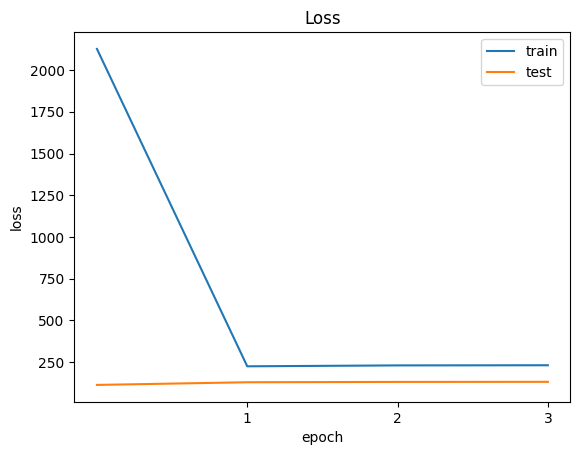

In [62]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper right') 
plt.xticks(range(1, 4))
plt.show()

In [56]:
#Let's try a simpler model like a random forest.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfClassifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Yyperparameter for gridcv
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfClassifier, param_grid=param_grid, 
                           scoring='r2', cv=3, n_jobs=-1)

#Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_search.best_estimator_


#Train the model
best_model.fit(X_train, y_train)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("R2 Train:", r2_score(y_train,y_train_pred))

print("MSE Test:", mean_squared_error(y_test,y_test_pred))
print("R2 Test:", r2_score(y_test,y_test_pred))

C:\Users\ARDA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MSE Train: 1.7422680412371134
R2 Train: 0.9877208016047676
MSE Test: 194.96
R2 Test: 0.003157825845086615


**This is, unfortunately, not very useful again. It is also an overfit I think. We have really good R2 on training data, but really bad on test data.**

#### Predicting and Analyzing 

In [57]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [58]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 141.8877670315669
Node 1 has MSE 341.1479289940835
Node 2 has MSE 162.8703999999998
Node 3 has MSE 108.16493055555566
Node 4 has MSE 23.972318339101548
Node 5 has MSE 17.555555555556566
Node 6 has MSE 0.9600000000009459
Node 7 has MSE 0.1875
Node 8 has MSE 0.0
Node 9 has MSE 0.0
Node 10 has MSE 0.0
Node 11 has MSE 3.1875
Node 12 has MSE 0.8888888888886868
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 0.0
Node 16 has MSE 14.6875
Node 17 has MSE 4.805555555556566
Node 18 has MSE 0.0
Node 19 has MSE 1.6000000000003638
Node 20 has MSE 0.0
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.25
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 210.7755102040819
Node 28 has MSE 96.55555555555657
Node 29 has MSE 64.23999999999887
Node 30 has MSE 25.0
Node 31 has MSE 0.0
Node 32 has MSE 0.0
Node 33 has MSE 8.222222222220807
Node 34 has MSE 2.25
Node 35 has MSE 0.0
Node 36 has MSE 0.0
Node 37 has MSE 0.0
Node 38 has MSE 0.0
Node 39 has MS

In [43]:
# Plotting the Tree 
#dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
#graph = graphviz.Source(dot_data)
#graph.render("hw")

In [59]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.3743061062648692
MSE TEST: 261.0771597633136
R2 Train: 0.9973619564667503
R2 TEST: -0.3349031778859828


**Another case of overfitting. This single tree is not useful either.**

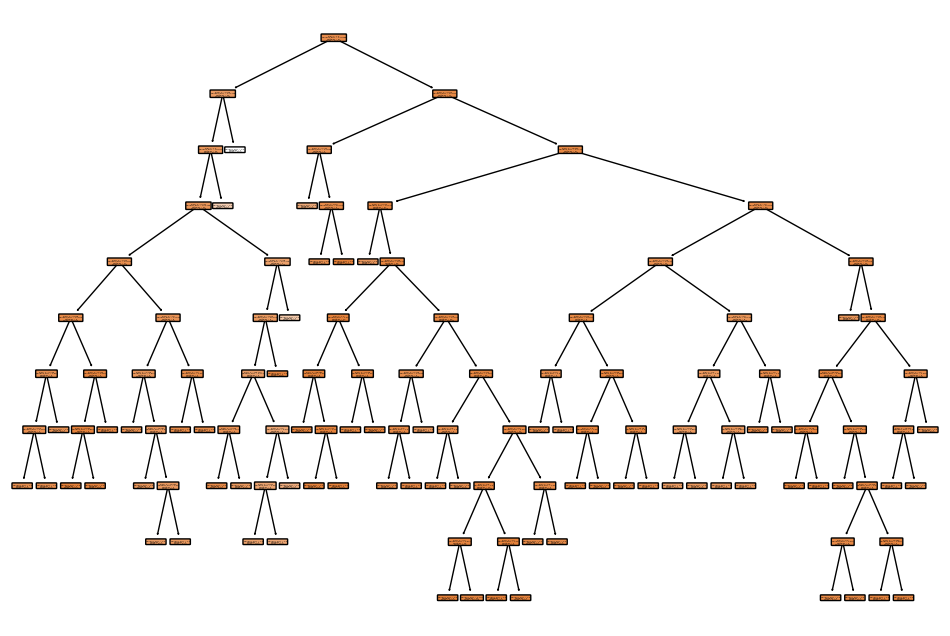

In [60]:
#Let's see what this tree looks like (without graphviz)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(regressor, filled=True, rounded=True)
plt.show()